In [1]:
# imports and env't config 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import requests 
from imp import reload 
import Util as util; reload(util)
from pygeocoder import Geocoder as gc
import warnings
from pygeolib import GeocoderError
import time 
from scipy.stats import kstest, ks_2samp

import Cdf
import Pmf
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
apr = pd.read_csv('../dataset/monroe_weblar_merged_201804.csv', sep = ',', encoding = "ISO-8859-1")
jul = pd.read_csv('../dataset/monroe_weblar_merged_201807.csv', sep = ',', encoding = "ISO-8859-1")
apr['atf'] = -1
apr['tlsHandshake'] = -1
frames = [apr, jul]
df = pd.concat(frames, ignore_index =  True)
# df = pd.read_csv('../../dataset/2018-weblar/monroe_weblar_merged_080918.csv', sep = ',', encoding = "ISO-8859-1")

df['3sec_rendering_time'] = df['3sec_rendering_time'].div(1000)
df['10sec_rendering_time'] = df['10sec_rendering_time'].div(1000)
df['14sec_rendering_time'] = df['14sec_rendering_time'].div(1000)
df['atf_instant'] = df['atf_instant'].div(1000)
df['atf_integral'] = df['atf_integral'].div(1000)
df['pltUserTime'] = df['pltUserTime'].div(1000)

df['operator'] = df['operator'].apply(lambda x: util.change_op_cc(x))
df['m_dtime'] = df['measurement_id'].apply(lambda x: util.get_measurement_dtime(x))
df['weekday'] = df['measurement_id'].apply(lambda x: util.weekday(x))
df = df[df['operator'] != 'Misc']
df = df[df['atf_instant'] > 0]
df = df[df['3sec_rendering_time'] > 0]


targets = set(df['url'])
operators = set(df['operator'])

In [3]:
bbc = df[df['url'] == 'http://www.bbc.com/']
wiki = df[df['url'] == 'https://en.wikipedia.org/wiki/Alan_Turing']
ggl = df[df['url'] == 'https://news.google.com/']
amzn = df[df['url'] == 'https://www.amazon.com/']
eby = df[df['url'] == 'https://www.ebay.com/']
fb = df[df['url'] == 'https://www.facebook.com/places/Things-to-do-in-Paris-France/110774245616525/']
ms = df[df['url'] == 'https://www.microsoft.com/']
rdt = df[df['url'] == 'https://www.reddit.com/']
yah = df[df['url'] == 'https://www.yahoo.com/']
ut = df[df['url'] == 'https://www.youtube.com/']
set(df['url'])

{'http://www.bbc.com/',
 'https://en.wikipedia.org/wiki/Alan_Turing',
 'https://news.google.com/',
 'https://www.amazon.com/',
 'https://www.ebay.com/',
 'https://www.facebook.com/places/Things-to-do-in-Paris-France/110774245616525/',
 'https://www.microsoft.com/',
 'https://www.reddit.com/',
 'https://www.yahoo.com/',
 'https://www.youtube.com/'}

## Dataset profiling 

In [4]:
for op in set(df['operator']):
    print("%s : %d " %(str(op), df[df['operator'] == op]['measurement_id'].count()))

SE_r : 725 
NO_3 : 3576 
NO_1 : 2154 
SE_1 : 2145 
SE_3 : 1702 
NO_2 : 3730 
SE_2 : 1769 


## ATF instant b

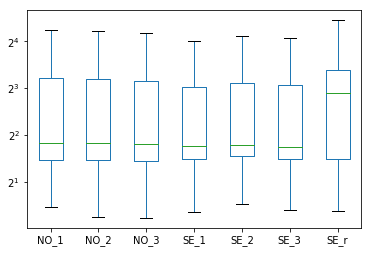

In [5]:
fig, ax = plt.subplots()
x = df.pivot(columns='operator', values='atf_instant')
x.boxplot(ax = ax, showfliers=False )
ax.grid(False)    
# ax.set_ylim([2000,20000])
ax.set_yscale('log', basey = 2)

In [6]:
df.groupby('operator')['atf_instant'].describe()

,count,mean,std,min,25%,50%,75%,max
operator,,,,,,,,
NO_1,2154.0,6.300778,4.837951,1.3904,2.765925,3.56120,9.268375,30.7490
NO_2,3730.0,6.187502,4.732506,1.2028,2.774750,3.54875,9.200075,30.7503
NO_3,3576.0,6.190482,4.863923,1.1802,2.749075,3.49715,8.906400,29.0625
SE_1,2145.0,5.806875,4.193350,1.2910,2.805100,3.41150,8.170800,19.3558
SE_2,1769.0,5.977734,4.152048,1.4439,2.928700,3.48090,8.696300,27.8749
SE_3,1702.0,5.759008,3.991816,1.3264,2.809600,3.38740,8.445600,18.1584
SE_r,725.0,7.423932,5.145065,1.3176,2.837500,7.51060,10.522700,32.3284


## ATF p

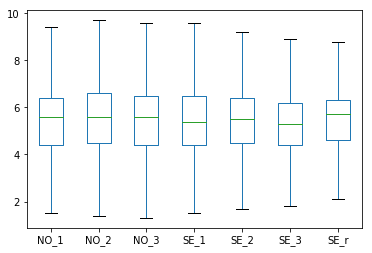

In [7]:
fig, ax = plt.subplots()
x = df.pivot(columns='operator', values='3sec_rendering_time')
x.boxplot(ax = ax, showfliers=False )
ax.grid(False)    
# ax.set_ylim([1000,12000])
# ax.set_yscale('log')

In [8]:
df.groupby('operator')['3sec_rendering_time'].describe()

,count,mean,std,min,25%,50%,75%,max
operator,,,,,,,,
NO_1,2154.0,5.479109,2.329761,1.3,4.4,5.6,6.4,15.5
NO_2,3730.0,5.636354,2.379916,1.3,4.5,5.6,6.6,16.4
NO_3,3576.0,5.556012,2.379595,1.3,4.4,5.6,6.5,32.3
SE_1,2145.0,5.461818,1.953320,1.5,4.4,5.4,6.5,17.5
SE_2,1769.0,5.471283,1.975750,1.7,4.5,5.5,6.4,15.4
SE_3,1702.0,5.370094,1.892460,1.8,4.4,5.3,6.2,16.4
SE_r,725.0,5.387448,1.846871,1.3,4.6,5.7,6.3,13.5


## PLT

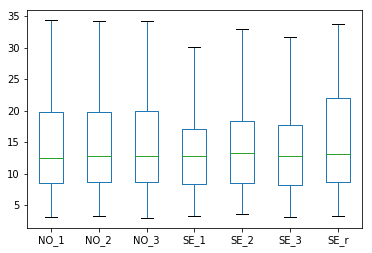

In [9]:
fig, ax = plt.subplots()
x = df.pivot(columns='operator', values='pltUserTime')
x.boxplot(ax = ax, showfliers=False )
ax.grid(False)    
# ax.set_ylim([3000,25000])
# ax.set_yscale('log')

In [10]:
df.groupby('operator')['pltUserTime'].describe()

,count,mean,std,min,25%,50%,75%,max
operator,,,,,,,,
NO_1,2154.0,14.077819,7.530697,3.116,8.55100,12.4955,19.81400,34.322
NO_2,3730.0,14.021413,7.269836,3.283,8.62325,12.8095,19.70750,34.143
NO_3,3576.0,14.091763,7.316337,2.942,8.58275,12.7480,19.95150,34.265
SE_1,2145.0,13.431577,6.656327,3.223,8.28400,12.7270,17.07400,33.977
SE_2,1769.0,13.863141,6.953076,3.536,8.42200,13.2530,18.34400,33.939
SE_3,1702.0,13.659624,6.847526,3.122,8.24925,12.8190,17.64125,34.119
SE_r,725.0,14.809530,8.070608,3.325,8.64600,13.0620,22.02900,33.715


## DNS Lookup time 

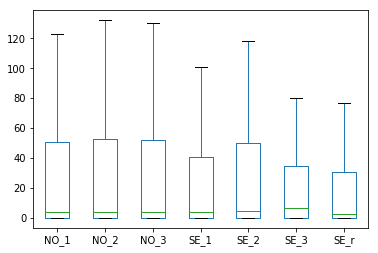

In [11]:
fig, ax = plt.subplots()
x = df.pivot(columns='operator', values='dnsLookup')
x.boxplot(ax = ax, showfliers=False )
ax.grid(False)    
# ax.set_ylim([3000,25000])
# ax.set_yscale('log')

In [12]:
df.groupby('operator')['dnsLookup'].describe()

,count,mean,std,min,25%,50%,75%,max
operator,,,,,,,,
NO_1,2154.0,29.732126,41.533295,0.0,0.0,4.0,50.75,459.0
NO_2,3730.0,44.973995,91.153671,0.0,0.0,4.0,53.00,890.0
NO_3,3576.0,48.051174,99.814619,0.0,0.0,4.0,52.00,1136.0
SE_1,2145.0,22.626573,29.180712,0.0,0.0,4.0,41.00,674.0
SE_2,1769.0,25.460147,27.872279,0.0,0.0,5.0,50.00,295.0
SE_3,1702.0,18.811986,20.905428,0.0,0.0,7.0,35.00,197.0
SE_r,725.0,18.878621,33.145613,0.0,0.0,3.0,31.00,252.0


In [13]:
df.groupby('operator')['pltUserTime'].describe()

,count,mean,std,min,25%,50%,75%,max
operator,,,,,,,,
NO_1,2154.0,14.077819,7.530697,3.116,8.55100,12.4955,19.81400,34.322
NO_2,3730.0,14.021413,7.269836,3.283,8.62325,12.8095,19.70750,34.143
NO_3,3576.0,14.091763,7.316337,2.942,8.58275,12.7480,19.95150,34.265
SE_1,2145.0,13.431577,6.656327,3.223,8.28400,12.7270,17.07400,33.977
SE_2,1769.0,13.863141,6.953076,3.536,8.42200,13.2530,18.34400,33.939
SE_3,1702.0,13.659624,6.847526,3.122,8.24925,12.8190,17.64125,34.119
SE_r,725.0,14.809530,8.070608,3.325,8.64600,13.0620,22.02900,33.715


In [14]:
df[['atf','atf_instant','3sec_rendering_time', 'pltUserTime', 'measurement_id']].tail()

,atf,atf_instant,3sec_rendering_time,pltUserTime,measurement_id
18387,12183.6,12.1836,4.5,10.262,471_op0_20180705165110
18388,2642.0,2.5802,7.4,9.695,45_op0_20180706231844
18389,22000.0,4.3884,5.8,23.020,460_op0_20180705224145
18391,13353.1,13.1671,4.4,11.136,440_op0_20180706165421
18392,11527.3,11.5083,4.0,9.255,483_op0_20180705225459


## All website

In [15]:
d = []
for o in sorted(set(df['operator'])):
    if o == 'Misc':
        continue
    df_o = df[df['operator'] != o]
    for p in sorted(set(df_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = df[df['operator'] == o]
        df_2 = df[df['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.04259000649704646, pvalue=0.013656333289563345)
NO_1 NO_3: Ks_2sampResult(statistic=0.04701881313367357, pvalue=0.005038895542803085)
NO_1 SE_1: Ks_2sampResult(statistic=0.0923946990799358, pvalue=1.8696442682319267e-08)
NO_1 SE_2: Ks_2sampResult(statistic=0.09181912993455321, pvalue=1.3546002607730384e-07)
NO_1 SE_3: Ks_2sampResult(statistic=0.09937623223320213, pvalue=1.2025137384362057e-08)
NO_1 SE_r: Ks_2sampResult(statistic=0.17668171485287998, pvalue=2.72622048876028e-15)
NO_2 NO_3: Ks_2sampResult(statistic=0.01689442875050229, pvalue=0.6711056555905974)
NO_2 SE_1: Ks_2sampResult(statistic=0.08143822218889252, pvalue=2.5324630662283558e-08)
NO_2 SE_2: Ks_2sampResult(statistic=0.08961879979449469, pvalue=7.4237166379963535e-09)
NO_2 SE_3: Ks_2sampResult(statistic=0.08292467779587487, pvalue=1.862324683318449e-07)
NO_2 SE_r: Ks_2sampResult(statistic=0.1777849681057595, pvalue=2.932904703485775e-17)
NO_3 SE_1: Ks_2sampResult(statistic=0.09122236

In [16]:
d = []
for o in sorted(set(df['operator'])):
    if o == 'Misc':
        continue
    df_o = df[df['operator'] != o]
    for p in sorted(set(df_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = df[df['operator'] == o]
        df_2 = df[df['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['3sec_rendering_time'], df_2['3sec_rendering_time'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.05326408129024873, pvalue=0.000819882163707159)
NO_1 NO_3: Ks_2sampResult(statistic=0.03571005714356934, pvalue=0.06339367190815652)
NO_1 SE_1: Ks_2sampResult(statistic=0.08743401445351306, pvalue=1.2906217341734156e-07)
NO_1 SE_2: Ks_2sampResult(statistic=0.07698745494598241, pvalue=1.8232965182275724e-05)
NO_1 SE_3: Ks_2sampResult(statistic=0.08752933628796533, pvalue=8.38177074347202e-07)
NO_1 SE_r: Ks_2sampResult(statistic=0.05708705535811481, pvalue=0.056117142324424746)
NO_2 NO_3: Ks_2sampResult(statistic=0.023124373991639136, pvalue=0.27988856168298665)
NO_2 SE_1: Ks_2sampResult(statistic=0.06383321772061712, pvalue=2.811731491991145e-05)
NO_2 SE_2: Ks_2sampResult(statistic=0.052038003325063587, pvalue=0.0028746693213725703)
NO_2 SE_3: Ks_2sampResult(statistic=0.10183855612227216, pvalue=4.976961698431998e-11)
NO_2 SE_r: Ks_2sampResult(statistic=0.06710548211149114, pvalue=0.007993083539027128)
NO_3 SE_1: Ks_2sampResult(statistic=0.058704103

In [17]:
d = []
for o in sorted(set(df['operator'])):
    if o == 'Misc':
        continue
    df_o = df[df['operator'] != o]
    for p in sorted(set(df_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = df[df['operator'] == o]
        df_2 = df[df['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['pltUserTime'], df_2['pltUserTime'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.03986373627467821, pvalue=0.02533496202961671)
NO_1 NO_3: Ks_2sampResult(statistic=0.03768390944271005, pvalue=0.04283180138014091)
NO_1 SE_1: Ks_2sampResult(statistic=0.09562174130419254, pvalue=5.0244941964426275e-09)
NO_1 SE_2: Ks_2sampResult(statistic=0.06693923461576212, pvalue=0.0003095006154017352)
NO_1 SE_3: Ks_2sampResult(statistic=0.07748216910140127, pvalue=2.011164548586447e-05)
NO_1 SE_r: Ks_2sampResult(statistic=0.07184004098229435, pvalue=0.0069715893937214325)
NO_2 NO_3: Ks_2sampResult(statistic=0.019835843364461314, pvalue=0.4653514445107318)
NO_2 SE_1: Ks_2sampResult(statistic=0.08939612666154217, pvalue=6.091081561387972e-10)
NO_2 SE_2: Ks_2sampResult(statistic=0.06252771517814248, pvalue=0.00015744976775088908)
NO_2 SE_3: Ks_2sampResult(statistic=0.07235171994467948, pvalue=8.885169760259964e-06)
NO_2 SE_r: Ks_2sampResult(statistic=0.10970139595081818, pvalue=7.792384093391531e-07)
NO_3 SE_1: Ks_2sampResult(statistic=0.095295755

## BBC

In [18]:
d = []
for o in sorted(set(bbc['operator'])):
    if o == 'Misc':
        continue
    bbc_o = bbc[bbc['operator'] != o]
    for p in sorted(set(bbc_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = bbc[bbc['operator'] == o]
        df_2 = bbc[bbc['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.08203390684434592, pvalue=0.08012171683009134)
NO_1 NO_3: Ks_2sampResult(statistic=0.04731667703365816, pvalue=0.664661346351977)
NO_1 SE_1: Ks_2sampResult(statistic=0.26868184675863366, pvalue=2.6195377578242847e-12)
NO_1 SE_2: Ks_2sampResult(statistic=0.2883403361344538, pvalue=5.413887351869925e-12)
NO_1 SE_3: Ks_2sampResult(statistic=0.2941115488285299, pvalue=3.755180338599635e-12)
NO_1 SE_r: Ks_2sampResult(statistic=0.2772911051212938, pvalue=2.4601709396401463e-06)
NO_2 NO_3: Ks_2sampResult(statistic=0.0507578480709322, pvalue=0.37999387700937604)
NO_2 SE_1: Ks_2sampResult(statistic=0.22519272046971178, pvalue=5.447666671200784e-11)
NO_2 SE_2: Ks_2sampResult(statistic=0.22158466190214404, pvalue=1.0033793731571902e-08)
NO_2 SE_3: Ks_2sampResult(statistic=0.23353702372393959, pvalue=2.33689528589594e-09)
NO_2 SE_r: Ks_2sampResult(statistic=0.2971183800623053, pvalue=6.177468980930967e-08)
NO_3 SE_1: Ks_2sampResult(statistic=0.2332654499209459

## Wiki

In [19]:
d = []
for o in sorted(set(wiki['operator'])):
    if o == 'Misc':
        continue
    wiki_o = wiki[wiki['operator'] != o]
    for p in sorted(set(wiki_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = wiki[wiki['operator'] == o]
        df_2 = wiki[wiki['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.1929567110092274, pvalue=8.939507151551168e-10)
NO_1 NO_3: Ks_2sampResult(statistic=0.20080005470459517, pvalue=2.803979316066585e-10)
NO_1 SE_1: Ks_2sampResult(statistic=0.2808147575791025, pvalue=5.8930564198062e-14)
NO_1 SE_2: Ks_2sampResult(statistic=0.18069220104565117, pvalue=3.04708984523228e-05)
NO_1 SE_3: Ks_2sampResult(statistic=0.2603184184712895, pvalue=2.1227077456322888e-10)
NO_1 SE_r: Ks_2sampResult(statistic=0.2695060956548921, pvalue=2.3343432038341287e-07)
NO_2 NO_3: Ks_2sampResult(statistic=0.034872534872534874, pvalue=0.7600933445706628)
NO_2 SE_1: Ks_2sampResult(statistic=0.11092663243998555, pvalue=0.005862634774135343)
NO_2 SE_2: Ks_2sampResult(statistic=0.10753665333818008, pvalue=0.020449279681739166)
NO_2 SE_3: Ks_2sampResult(statistic=0.09158912607188469, pvalue=0.07265646560280303)
NO_2 SE_r: Ks_2sampResult(statistic=0.23042328042328042, pvalue=5.274269684278686e-06)
NO_3 SE_1: Ks_2sampResult(statistic=0.0989470933369301

## Google

In [20]:
d = []
for o in sorted(set(ggl['operator'])):
    if o == 'Misc':
        continue
    ggl_o = ggl[ggl['operator'] != o]
    for p in sorted(set(ggl_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = ggl[ggl['operator'] == o]
        df_2 = ggl[ggl['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.138256221395881, pvalue=4.040011997795296e-05)
NO_1 NO_3: Ks_2sampResult(statistic=0.2035407260807719, pvalue=1.830765044198725e-10)
NO_1 SE_1: Ks_2sampResult(statistic=0.32070938215102973, pvalue=6.541977922316997e-19)
NO_1 SE_2: Ks_2sampResult(statistic=0.23280892448512586, pvalue=2.7526022638772395e-09)
NO_1 SE_3: Ks_2sampResult(statistic=0.24937310733224627, pvalue=7.661906526209695e-11)
NO_1 SE_r: Ks_2sampResult(statistic=0.5361832995671121, pvalue=5.6897048468977154e-30)
NO_2 NO_3: Ks_2sampResult(statistic=0.11489301801801799, pvalue=8.391067087429964e-05)
NO_2 SE_1: Ks_2sampResult(statistic=0.20781249999999996, pvalue=4.099764977489914e-10)
NO_2 SE_2: Ks_2sampResult(statistic=0.13151041666666669, pvalue=0.0007080066258936102)
NO_2 SE_3: Ks_2sampResult(statistic=0.15030096057884235, pvalue=4.5415293240366286e-05)
NO_2 SE_r: Ks_2sampResult(statistic=0.5503333996815287, pvalue=1.6846123048941793e-35)
NO_3 SE_1: Ks_2sampResult(statistic=0.169985

 ## Reddit

In [21]:
d = []
for o in sorted(set(rdt['operator'])):
    if o == 'Misc':
        continue
    rdt_o = rdt[rdt['operator'] != o]
    for p in sorted(set(rdt_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = rdt[rdt['operator'] == o]
        df_2 = rdt[rdt['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.10903710448440707, pvalue=0.09738734917035971)
NO_1 NO_3: Ks_2sampResult(statistic=0.13480173403034557, pvalue=0.02341779993524935)
NO_1 SE_1: Ks_2sampResult(statistic=0.18740017746228932, pvalue=0.001031243696086435)
NO_1 SE_2: Ks_2sampResult(statistic=0.1253555465258026, pvalue=0.08218995920679877)
NO_1 SE_3: Ks_2sampResult(statistic=0.2874102997045166, pvalue=1.3833498286331354e-07)
NO_1 SE_r: Ks_2sampResult(statistic=0.11146071700991608, pvalue=0.6262824061370407)
NO_2 NO_3: Ks_2sampResult(statistic=0.12288311249635347, pvalue=0.007809048842061449)
NO_2 SE_1: Ks_2sampResult(statistic=0.14872315418313925, pvalue=0.0023575054382792295)
NO_2 SE_2: Ks_2sampResult(statistic=0.052429417233449155, pvalue=0.835580654664056)
NO_2 SE_3: Ks_2sampResult(statistic=0.2719717379149087, pvalue=3.2291360055533083e-09)
NO_2 SE_r: Ks_2sampResult(statistic=0.13653899145770187, pvalue=0.29192781259582923)
NO_3 SE_1: Ks_2sampResult(statistic=0.09919205218744387, pva

## Yahoo

In [22]:
d = []
for o in sorted(set(yah['operator'])):
    if o == 'Misc':
        continue
    yah_o = yah[yah['operator'] != o]
    for p in sorted(set(yah_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = yah[yah['operator'] == o]
        df_2 = yah[yah['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.22635561160151324, pvalue=0.04011388606346298)
NO_1 NO_3: Ks_2sampResult(statistic=0.20692307692307693, pvalue=0.07452001877390516)
NO_1 SE_1: Ks_2sampResult(statistic=0.9059392987964416, pvalue=4.8680940029376615e-29)
NO_1 SE_2: Ks_2sampResult(statistic=0.7195853791598472, pvalue=2.7674697597802334e-18)
NO_1 SE_3: Ks_2sampResult(statistic=0.7439271255060729, pvalue=2.139943288054344e-18)
NO_1 SE_r: Ks_2sampResult(statistic=0.8642533936651584, pvalue=1.8808086706748614e-09)
NO_2 NO_3: Ks_2sampResult(statistic=0.1407868852459016, pvalue=0.1589649187293441)
NO_2 SE_1: Ks_2sampResult(statistic=0.9344262295081968, pvalue=1.1800087817552274e-52)
NO_2 SE_2: Ks_2sampResult(statistic=0.8874549470991745, pvalue=1.1668432287760112e-46)
NO_2 SE_3: Ks_2sampResult(statistic=0.8846706931262582, pvalue=6.682865719240744e-42)
NO_2 SE_r: Ks_2sampResult(statistic=0.9262295081967213, pvalue=2.048203509758098e-12)
NO_3 SE_1: Ks_2sampResult(statistic=0.912, pvalue=7.93

## YouTube

In [23]:
d = []
for o in sorted(set(ut['operator'])):
    if o == 'Misc':
        continue
    ut_o = ut[ut['operator'] != o]
    for p in sorted(set(ut_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = ut[ut['operator'] == o]
        df_2 = ut[ut['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)

NO_1 NO_2: Ks_2sampResult(statistic=0.11900161030595813, pvalue=0.6477216203606566)
NO_1 NO_3: Ks_2sampResult(statistic=0.17738791423001948, pvalue=0.17904989803908933)
NO_1 SE_1: Ks_2sampResult(statistic=0.23851294903926484, pvalue=0.00981240539854942)
NO_1 SE_2: Ks_2sampResult(statistic=0.20206166757890892, pvalue=0.05300509959248357)
NO_1 SE_3: Ks_2sampResult(statistic=0.28980526918671246, pvalue=0.0012253534772891591)
NO_1 SE_r: Ks_2sampResult(statistic=0.2707707707707708, pvalue=0.06544400319812906)
NO_2 NO_3: Ks_2sampResult(statistic=0.11876430205949662, pvalue=0.3729106877483351)
NO_2 SE_1: Ks_2sampResult(statistic=0.1751552795031056, pvalue=0.012527965360341552)
NO_2 SE_2: Ks_2sampResult(statistic=0.14966802313129146, pvalue=0.06729999710946219)
NO_2 SE_3: Ks_2sampResult(statistic=0.22877633348274312, pvalue=0.0008226632115059821)
NO_2 SE_r: Ks_2sampResult(statistic=0.3102232667450059, pvalue=0.006836285113649404)
NO_3 SE_1: Ks_2sampResult(statistic=0.15037593984962408, pvalue=

## Microsoft

In [24]:
d = []
for o in sorted(set(ms['operator'])):
    if o == 'Misc':
        continue
    ms_o = ms[ms['operator'] != o]
    for p in sorted(set(ms_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = ms[ms['operator'] == o]
        df_2 = ms[ms['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.30481180134720776, pvalue=6.501768301816302e-22)
NO_1 NO_3: Ks_2sampResult(statistic=0.32586408161193725, pvalue=1.6347062657911323e-24)
NO_1 SE_1: Ks_2sampResult(statistic=0.23559718969555032, pvalue=3.610655795905839e-09)
NO_1 SE_2: Ks_2sampResult(statistic=0.12034566018553819, pvalue=0.017242354446078315)
NO_1 SE_3: Ks_2sampResult(statistic=0.4272887169969002, pvalue=2.2961252096420078e-25)
NO_1 SE_r: Ks_2sampResult(statistic=0.29859484777517564, pvalue=1.0377513159866468e-08)
NO_2 NO_3: Ks_2sampResult(statistic=0.05174245498524965, pvalue=0.33000069588040987)
NO_2 SE_1: Ks_2sampResult(statistic=0.11040343803568411, pvalue=0.010801082369575566)
NO_2 SE_2: Ks_2sampResult(statistic=0.38413763971184256, pvalue=7.714475200829394e-25)
NO_2 SE_3: Ks_2sampResult(statistic=0.1329145252659818, pvalue=0.0033032594788804056)
NO_2 SE_r: Ks_2sampResult(statistic=0.05946511280442246, pvalue=0.8003563066606599)
NO_3 SE_1: Ks_2sampResult(statistic=0.12367152210

## Facebook

In [25]:
d = []
for o in sorted(set(fb['operator'])):
    if o == 'Misc':
        continue
    fb_o = fb[fb['operator'] != o]
    for p in sorted(set(fb_o['operator'])):
        if p == 'Misc' or p in d:
            continue
        df_1 = fb[fb['operator'] == o]
        df_2 = fb[fb['operator'] == p]
        
        print('{} {}: {}'.format(o, p, ks_2samp(df_1['atf_instant'], df_2['atf_instant'])))
    d.append(o)


NO_1 NO_2: Ks_2sampResult(statistic=0.06816586222027199, pvalue=0.7027609468535638)
NO_1 NO_3: Ks_2sampResult(statistic=0.09999999999999998, pvalue=0.22457685177450895)
NO_1 SE_1: Ks_2sampResult(statistic=0.21162790697674422, pvalue=0.008348023673971418)
NO_1 SE_2: Ks_2sampResult(statistic=0.09800664451827241, pvalue=0.5646085073291681)
NO_1 SE_3: Ks_2sampResult(statistic=0.17012133468149648, pvalue=0.05515290623262504)
NO_1 SE_r: Ks_2sampResult(statistic=0.12015503875968991, pvalue=0.47116616510131953)
NO_2 NO_3: Ks_2sampResult(statistic=0.08517520215633423, pvalue=0.264821217603948)
NO_2 SE_1: Ks_2sampResult(statistic=0.2069182389937107, pvalue=0.005255002160889082)
NO_2 SE_2: Ks_2sampResult(statistic=0.08055448594532144, pvalue=0.7243970190460263)
NO_2 SE_3: Ks_2sampResult(statistic=0.13383921246923713, pvalue=0.1598478563146682)
NO_2 SE_r: Ks_2sampResult(statistic=0.12527158376214986, pvalue=0.35584456325087294)
NO_3 SE_1: Ks_2sampResult(statistic=0.24801587301587302, pvalue=0.0003